1. Marketing Lead Scoring Model
2. Call Fact and Lead Fact Data
3. Author: Sudesh Khillare

Approach: 
1. First some exploratory analysis of data. Find the missing values, use proper method to fill those values. Some of the data preprocessing, generating new feature, merging both the dataset, feature engineering, calculating impact of each variable.
2. For business case, I have converted the Latest Dispo Group into Ternary variable. I am considering Sale in one group i.e. Sales then Transfer Call, Agent Call Back into second group i.e. Predictive Sales and all other as Non-Sale. This target variable will provide the probability of each dial getting converted into sale.
3. Using Pearson Correlation, I'm considering variables in model building. I have taken 20% data as holdout dataset to validate my model on unseen data. This data is not equally distributed i.e. 51.85% belong to Potential Sale, 44.63% belong to No Sale and only 3.5% belongs to Sale. To handle this issue, I have used weight balancing in model training, and I have also experimented with ADASYN Oversampling technique on training data.
4. I am trying different Classification models and predicting probability of each call becoming a Sale. My results are validated with 20% unseen data. Using hyperparameter tuning, I have optimized my results.
5. I have designed Unsupervised Model by K Means Clustering. Using Elbow Curve, I have identified the optimal number of clusters. At last I have created business insight and how we can use this clustering in business strategy.
6. Financial Impact: Each Lead cost is given. To calculate the financial impact, I am considering all the correctly identified No Sale leads cost as money saved. For Money Lost, I am considering the cost from all the leads which were No Sale but my model predicted them as Sale or Potential Sale. There should be penalty for model for missing each misclassified sale as well, but as I don't have business knowledge, I'm not sure how each lead brings profit to company. If I get that idea, then I can add all the money lost because of False Negative, i.e. wrongly identifying as not sale as loss. 
7. I have also analysed the possible reason for models getting confused between Sale and No Sale. I believe with few more variables and some business understanding, I can further optimize the performance of the model.
8. At last, I have added some business recommendation based on my analysis and model output. How this data can be used for better customer segmentation, optimizing sales, increasing throughput rate and increasing profit.


In [1]:
#Importing all the required libraries
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from statistics import mean 
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# 1. Data Preprocessing

In [2]:
#Importing both the datasets in Call_Facts and Lead_Facts
Work_Book = pd.ExcelFile('Copy of Data Assessment - Data Scientist 201807.xlsx')
Call_Facts = pd.read_excel(Work_Book, 'Call Facts')
Lead_Facts = pd.read_excel(Work_Book, 'Lead Facts')

There are 25 entries in Calls Facts which are Forcibly Terminated, Those entries are excluded from the consideration as they doesn't add value to the model and they are not present in Lead_Facts

In [3]:
#Generating new feature to calculate, fo how many days Lead was followed.
#Considering Call Fact Data.
Date_Call_Facts = Call_Facts.groupby('dialerLeadId').callDate.max() - Call_Facts.groupby('dialerLeadId').callDate.min()
Date_Call_Facts = Date_Call_Facts.reset_index()
Date_Call_Facts = Date_Call_Facts.rename(columns={'callDate': 'DaysDifference'})
Date_Call_Facts.head()

,dialerLeadId,DaysDifference
0,2311300,13 days 02:09:01.966000
1,2311301,0 days 00:00:00
2,2311310,15 days 05:13:34.670000
3,2311317,0 days 00:07:59.456000
4,2311318,13 days 01:36:49.224000


In [4]:
#Confirming DaysDifference format to convert it into simple days.
Date_Call_Facts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27776 entries, 0 to 27775
Data columns (total 2 columns):
dialerLeadId      27776 non-null int64
DaysDifference    27776 non-null timedelta64[ns]
dtypes: int64(1), timedelta64[ns](1)
memory usage: 434.1 KB


In [5]:
Date_Call_Facts['DaysDifference'] = Date_Call_Facts['DaysDifference'].dt.days
Date_Call_Facts.head()

,dialerLeadId,DaysDifference
0,2311300,13
1,2311301,0
2,2311310,15
3,2311317,0
4,2311318,13


In [6]:
#Now we want days for each lead, thus merging this new data with old Lead Facts on dialerLeadId
Lead_Facts = pd.merge(Lead_Facts,Date_Call_Facts,on ='dialerLeadId',how='left')

In [7]:
Lead_Facts.shape

(31020, 49)

In [8]:
#Now many of the features from call facts are important for consideration into model.
#Call facts is having around 27000 dialerLeadId which are also from Lead Facts Table.
#Thus fetching only numerical variables from Call Facts w.r.t dialerLeadId based on intuitive business understanding for further processing

FilteredCall_Facts = Call_Facts[['dialerLeadId','inboundCallsHandled','outboundCalls','handleTimeSeconds','talkTimeSeconds','callAttemptNumber']]

In [9]:
#Call facts is having multiple entries for same LeadId, thus aggregrating the entries for quantifying the results.
Grouped_FilteredCall_Facts = FilteredCall_Facts.groupby('dialerLeadId').sum()
Grouped_FilteredCall_Facts = Grouped_FilteredCall_Facts.reset_index()

#Renaming Columns for better understanding
Grouped_FilteredCall_Facts = Grouped_FilteredCall_Facts.rename(columns={'inboundCallsHandled': 'SuminboundCallsHandled','outboundCalls': 'SumoutboundCalls','handleTimeSeconds': 'SumhandleTimeSeconds','talkTimeSeconds': 'SumtalkTimeSeconds','callAttemptNumber': 'SumcallAttemptNumber'})
Grouped_FilteredCall_Facts.head()

,dialerLeadId,SuminboundCallsHandled,SumoutboundCalls,SumhandleTimeSeconds,SumtalkTimeSeconds,SumcallAttemptNumber
0,2311300,0,5,127,77.0,15
1,2311301,0,1,802,779.0,1
2,2311310,0,6,394,239.0,28
3,2311317,1,1,440,400.0,3
4,2311318,0,5,396,60.0,15


In [10]:
#Now these numerical variable are important for model building.
#Thus, merging with Lead Facts Table on common key dialerLeadId.
#There are around 3000 additional datapoints in Lead_Facts table, so taking left join to not truncate the table.
#For handling the missing valuses, we will use data filling techniques to preserve additional datapoints and to maintain the integrity of the data.

Lead_Fact_Merged=pd.merge(Lead_Facts,Grouped_FilteredCall_Facts, on='dialerLeadId', how='left' )

#First Stage of Complete Dataset to be used in model building.
print(Lead_Fact_Merged.shape)
Lead_Fact_Merged.head()

(31020, 54)


,cdsLeadFactId,sourceSystem,sourceSystemId,cdsPersonId,dimProgramId,tztMarketingProject,dialerLeadId,omsMarketingProject,externalSystem,externalSystemId,leadDate,leadDateKey,dimMarketingSourceId,afid,campaign id,productOfInterest,originalContactType,originalInboundDnis,leadTypeId,leadZip,ageOnLeadGroup,gender,tobacco,leadCost,callCenterLeadCreatedReason,...,leadsAccepted,leadsRejected,rejectType,rejectReason,callCenterLeadsTotal,callCenterLeadEverContacted,callCenterLeadEverSold,callCenterLatestDispo,callCenterLatestDispoGroup,callCenterLatestDispoDescription,batchid,currentSkill,originalSkill,expirationInDays,maxAttempts,dailyMaxAttempts,leadType,deliveryMethod,everCallback,DaysDifference,SuminboundCallsHandled,SumoutboundCalls,SumhandleTimeSeconds,SumtalkTimeSeconds,SumcallAttemptNumber
0,13632067,tztLeads,9BA4CC14-FBBF-4BBE-8E27-A85B000CFDE5,7000068.0,7,377.0,2311300,NaN,NaN,142444921,2018-01-01 00:47:18,2018010100,NaN,363047.0,3.0,NaN,OB,NaN,15.0,97106.0,61 - 70,F,NaN,50.0,Import,...,1,0,NaN,NaN,1,0,0,AM,Still Workable,Answering Machine,20180101005000,22.0,2.0,30.0,12.0,5.0,Primary,Data,0.0,13.0,0.0,5.0,127.0,77.0,15.0
1,13632073,tztLeads,EF6E9B37-D03F-4D0A-AACB-A85B000E9612,7000072.0,7,377.0,2311301,NaN,NaN,142444965,2018-01-01 00:53:06,2018010100,NaN,363047.0,3.0,NaN,OB,NaN,15.0,47448.0,71 - 80,F,NaN,50.0,Import,...,1,0,NaN,NaN,1,1,0,RP,Transfer Call,Refer to other agent - Product,20180101010000,2.0,2.0,30.0,12.0,5.0,Primary,Data,0.0,0.0,0.0,1.0,802.0,779.0,1.0
2,13632079,tztLeads,0F0A9E1C-5C41-4E8B-8059-A85B0012BF8A,NaN,7,377.0,1800166535724,NaN,NaN,142445037,2018-01-01 01:08:15,2018010101,NaN,354814.0,7.0,NaN,OB,NaN,15.0,77803.0,71 - 80,F,NaN,0.0,Import,...,0,1,Failed Validation Check,The specified campaign is not active.,0,0,0,NaN,NaN,NaN,20180101012000,NaN,NaN,NaN,NaN,NaN,Shared,Data,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13632093,tztLeads,E5878541-F1CF-4EAC-9547-A85B0017233F,7000089.0,7,377.0,2311310,NaN,NaN,142445085,2018-01-01 01:24:14,2018010101,NaN,363047.0,3.0,NaN,OB,NaN,15.0,63114.0,61 - 70,F,NaN,50.0,Import,...,1,0,NaN,NaN,1,0,0,NaN,Still Workable,No Answer,20180101013000,22.0,2.0,30.0,12.0,5.0,Primary,Data,1.0,15.0,0.0,6.0,394.0,239.0,28.0
4,13632099,tztLeads,0A3858CD-BA9B-40C1-8D6E-A85B001CC53E,7000096.0,7,377.0,2311318,NaN,NaN,142445239,2018-01-01 01:44:45,2018010101,NaN,363045.0,3.0,NaN,OB,NaN,15.0,77345.0,61 - 70,M,NaN,50.0,Import,...,1,0,NaN,NaN,1,0,0,NaN,Still Workable,No Answer,20180101015000,22.0,2.0,30.0,12.0,5.0,Primary,Data,0.0,13.0,0.0,5.0,396.0,60.0,15.0


In [11]:
#Designing new features to categorize all type of variables in sales folder. Creating 3 Buckets.
#Non Sale, Potential Sale and Sale. Setting default value as potential sale to not miss an opportunity
def Target_Creation(callCenterLatestDispoGroup):
    output='Potential_Sale'
    #Not Sale
    if callCenterLatestDispoGroup=='System disposition' or callCenterLatestDispoGroup=='Non Workable' or callCenterLatestDispoGroup=='No Sale' or callCenterLatestDispoGroup=='Do Not Call'  or callCenterLatestDispoGroup=='Null':
        output='No_Sale'
    #Potential Sale
    elif callCenterLatestDispoGroup=='Transfer Call' or callCenterLatestDispoGroup=='Agent Call Back' or callCenterLatestDispoGroup=='Still Workable':
        output='Potential_Sale'
    #Sale
    elif  callCenterLatestDispoGroup=='Sale':
        output = 'Sale'
    return output
         

Lead_Fact_Merged['Target_Variable']=Lead_Fact_Merged.apply(lambda x: Target_Creation(x.callCenterLatestDispoGroup),axis=1)
Lead_Fact_Merged.head()

,cdsLeadFactId,sourceSystem,sourceSystemId,cdsPersonId,dimProgramId,tztMarketingProject,dialerLeadId,omsMarketingProject,externalSystem,externalSystemId,leadDate,leadDateKey,dimMarketingSourceId,afid,campaign id,productOfInterest,originalContactType,originalInboundDnis,leadTypeId,leadZip,ageOnLeadGroup,gender,tobacco,leadCost,callCenterLeadCreatedReason,...,leadsRejected,rejectType,rejectReason,callCenterLeadsTotal,callCenterLeadEverContacted,callCenterLeadEverSold,callCenterLatestDispo,callCenterLatestDispoGroup,callCenterLatestDispoDescription,batchid,currentSkill,originalSkill,expirationInDays,maxAttempts,dailyMaxAttempts,leadType,deliveryMethod,everCallback,DaysDifference,SuminboundCallsHandled,SumoutboundCalls,SumhandleTimeSeconds,SumtalkTimeSeconds,SumcallAttemptNumber,Target_Variable
0,13632067,tztLeads,9BA4CC14-FBBF-4BBE-8E27-A85B000CFDE5,7000068.0,7,377.0,2311300,NaN,NaN,142444921,2018-01-01 00:47:18,2018010100,NaN,363047.0,3.0,NaN,OB,NaN,15.0,97106.0,61 - 70,F,NaN,50.0,Import,...,0,NaN,NaN,1,0,0,AM,Still Workable,Answering Machine,20180101005000,22.0,2.0,30.0,12.0,5.0,Primary,Data,0.0,13.0,0.0,5.0,127.0,77.0,15.0,Potential_Sale
1,13632073,tztLeads,EF6E9B37-D03F-4D0A-AACB-A85B000E9612,7000072.0,7,377.0,2311301,NaN,NaN,142444965,2018-01-01 00:53:06,2018010100,NaN,363047.0,3.0,NaN,OB,NaN,15.0,47448.0,71 - 80,F,NaN,50.0,Import,...,0,NaN,NaN,1,1,0,RP,Transfer Call,Refer to other agent - Product,20180101010000,2.0,2.0,30.0,12.0,5.0,Primary,Data,0.0,0.0,0.0,1.0,802.0,779.0,1.0,Potential_Sale
2,13632079,tztLeads,0F0A9E1C-5C41-4E8B-8059-A85B0012BF8A,NaN,7,377.0,1800166535724,NaN,NaN,142445037,2018-01-01 01:08:15,2018010101,NaN,354814.0,7.0,NaN,OB,NaN,15.0,77803.0,71 - 80,F,NaN,0.0,Import,...,1,Failed Validation Check,The specified campaign is not active.,0,0,0,NaN,NaN,NaN,20180101012000,NaN,NaN,NaN,NaN,NaN,Shared,Data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Potential_Sale
3,13632093,tztLeads,E5878541-F1CF-4EAC-9547-A85B0017233F,7000089.0,7,377.0,2311310,NaN,NaN,142445085,2018-01-01 01:24:14,2018010101,NaN,363047.0,3.0,NaN,OB,NaN,15.0,63114.0,61 - 70,F,NaN,50.0,Import,...,0,NaN,NaN,1,0,0,NaN,Still Workable,No Answer,20180101013000,22.0,2.0,30.0,12.0,5.0,Primary,Data,1.0,15.0,0.0,6.0,394.0,239.0,28.0,Potential_Sale
4,13632099,tztLeads,0A3858CD-BA9B-40C1-8D6E-A85B001CC53E,7000096.0,7,377.0,2311318,NaN,NaN,142445239,2018-01-01 01:44:45,2018010101,NaN,363045.0,3.0,NaN,OB,NaN,15.0,77345.0,61 - 70,M,NaN,50.0,Import,...,0,NaN,NaN,1,0,0,NaN,Still Workable,No Answer,20180101015000,22.0,2.0,30.0,12.0,5.0,Primary,Data,0.0,13.0,0.0,5.0,396.0,60.0,15.0,Potential_Sale


In [12]:
#Confirming Target Variable is not having any missing values.
#Thus data filling won't be a problem in further steps.
Lead_Fact_Merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31020 entries, 0 to 31019
Data columns (total 55 columns):
cdsLeadFactId                          31020 non-null int64
sourceSystem                           31020 non-null object
sourceSystemId                         31020 non-null object
cdsPersonId                            28598 non-null float64
dimProgramId                           31020 non-null int64
tztMarketingProject                    24753 non-null float64
dialerLeadId                           31020 non-null int64
omsMarketingProject                    0 non-null float64
externalSystem                         0 non-null float64
externalSystemId                       21387 non-null object
leadDate                               31020 non-null datetime64[ns]
leadDateKey                            31020 non-null int64
dimMarketingSourceId                   6505 non-null float64
afid                                   30779 non-null float64
campaign id                         

In [13]:
Lead_Fact_Merged['Target_Variable'].value_counts()

Potential_Sale    16086
No_Sale           13847
Sale               1087
Name: Target_Variable, dtype: int64

Text(0.5, 1.0, 'Target_Variable_Distribution')

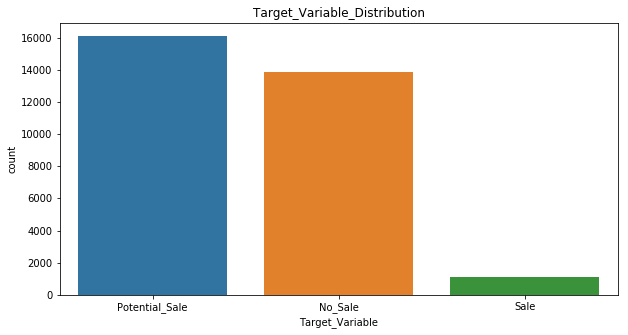

In [14]:
fig, axs = plt.subplots(figsize = (10,5))
sns.countplot(x = "Target_Variable", data = Lead_Fact_Merged)
plt.title('Target_Variable_Distribution')

In [15]:
#Converting all the zip codes into respective city names. This feature will be used in better visualization.

#First converting all the Zip Codes into Int values. As few of the rows have missing Zip Codes, filling those value by 0.
Lead_Fact_Merged['leadZip'] = Lead_Fact_Merged['leadZip'].fillna(value=0)
Lead_Fact_Merged['leadZip'] = Lead_Fact_Merged['leadZip'].apply(np.int64)

def City_Extract(leadZip):
    #Setting Default value as To Be Calculated
    output='To_Be_Calculated'
    #If Zip Code is not Provide or Null Value
    if leadZip=='NaN' or leadZip=='Null' or leadZip==0:
        return 'Not_Provided'
    #Using Search Engine to identiy cities from Zip Code. Passing only numeric values except 0
    elif(leadZip//10>0):
        search = SearchEngine()
        zipcode = search.by_zipcode(leadZip)
        output=zipcode.major_city
    return output
         

Lead_Fact_Merged['City_Name']=Lead_Fact_Merged.apply(lambda x: City_Extract(x.leadZip),axis=1)
Lead_Fact_Merged.head()

,cdsLeadFactId,sourceSystem,sourceSystemId,cdsPersonId,dimProgramId,tztMarketingProject,dialerLeadId,omsMarketingProject,externalSystem,externalSystemId,leadDate,leadDateKey,dimMarketingSourceId,afid,campaign id,productOfInterest,originalContactType,originalInboundDnis,leadTypeId,leadZip,ageOnLeadGroup,gender,tobacco,leadCost,callCenterLeadCreatedReason,...,rejectType,rejectReason,callCenterLeadsTotal,callCenterLeadEverContacted,callCenterLeadEverSold,callCenterLatestDispo,callCenterLatestDispoGroup,callCenterLatestDispoDescription,batchid,currentSkill,originalSkill,expirationInDays,maxAttempts,dailyMaxAttempts,leadType,deliveryMethod,everCallback,DaysDifference,SuminboundCallsHandled,SumoutboundCalls,SumhandleTimeSeconds,SumtalkTimeSeconds,SumcallAttemptNumber,Target_Variable,City_Name
0,13632067,tztLeads,9BA4CC14-FBBF-4BBE-8E27-A85B000CFDE5,7000068.0,7,377.0,2311300,NaN,NaN,142444921,2018-01-01 00:47:18,2018010100,NaN,363047.0,3.0,NaN,OB,NaN,15.0,97106,61 - 70,F,NaN,50.0,Import,...,NaN,NaN,1,0,0,AM,Still Workable,Answering Machine,20180101005000,22.0,2.0,30.0,12.0,5.0,Primary,Data,0.0,13.0,0.0,5.0,127.0,77.0,15.0,Potential_Sale,Banks
1,13632073,tztLeads,EF6E9B37-D03F-4D0A-AACB-A85B000E9612,7000072.0,7,377.0,2311301,NaN,NaN,142444965,2018-01-01 00:53:06,2018010100,NaN,363047.0,3.0,NaN,OB,NaN,15.0,47448,71 - 80,F,NaN,50.0,Import,...,NaN,NaN,1,1,0,RP,Transfer Call,Refer to other agent - Product,20180101010000,2.0,2.0,30.0,12.0,5.0,Primary,Data,0.0,0.0,0.0,1.0,802.0,779.0,1.0,Potential_Sale,Nashville
2,13632079,tztLeads,0F0A9E1C-5C41-4E8B-8059-A85B0012BF8A,NaN,7,377.0,1800166535724,NaN,NaN,142445037,2018-01-01 01:08:15,2018010101,NaN,354814.0,7.0,NaN,OB,NaN,15.0,77803,71 - 80,F,NaN,0.0,Import,...,Failed Validation Check,The specified campaign is not active.,0,0,0,NaN,NaN,NaN,20180101012000,NaN,NaN,NaN,NaN,NaN,Shared,Data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Potential_Sale,Bryan
3,13632093,tztLeads,E5878541-F1CF-4EAC-9547-A85B0017233F,7000089.0,7,377.0,2311310,NaN,NaN,142445085,2018-01-01 01:24:14,2018010101,NaN,363047.0,3.0,NaN,OB,NaN,15.0,63114,61 - 70,F,NaN,50.0,Import,...,NaN,NaN,1,0,0,NaN,Still Workable,No Answer,20180101013000,22.0,2.0,30.0,12.0,5.0,Primary,Data,1.0,15.0,0.0,6.0,394.0,239.0,28.0,Potential_Sale,Saint Louis
4,13632099,tztLeads,0A3858CD-BA9B-40C1-8D6E-A85B001CC53E,7000096.0,7,377.0,2311318,NaN,NaN,142445239,2018-01-01 01:44:45,2018010101,NaN,363045.0,3.0,NaN,OB,NaN,15.0,77345,61 - 70,M,NaN,50.0,Import,...,NaN,NaN,1,0,0,NaN,Still Workable,No Answer,20180101015000,22.0,2.0,30.0,12.0,5.0,Primary,Data,0.0,13.0,0.0,5.0,396.0,60.0,15.0,Potential_Sale,Kingwood


In [16]:
#Top 10 Cities with heighest dialLeads
Lead_Fact_Merged['City_Name'].value_counts().head(10)

Not_Provided      3600
Houston            329
Indianapolis       217
Las Vegas          216
Atlanta            200
Philadelphia       192
Phoenix            184
San Antonio        179
Salt Lake City     174
Dallas             161
Name: City_Name, dtype: int64

In [17]:
#Exporting Data for Tableau Visualization
Lead_Fact_Merged.to_csv('Lead_Fact_Merged_Before_Label_Encoding.csv', encoding='utf-8')

In [18]:
#Label Encoding
#Label Encoding: Categorical Variable
#Only considering those variable which might be useful for modelling purpose from business intuition.
from sklearn.preprocessing  import LabelEncoder
def MultilabelEncoder(ColumnList, DataFrame):
    for i in ColumnList:
        labelencoder_x=LabelEncoder()
        DataFrame[i]=labelencoder_x.fit_transform(DataFrame[i].astype(str))
        
        
ColumnList=['sourceSystem','originalContactType','originalContactType','originalContactType','callCenterLeadCreatedReason','rejectType','leadType','deliveryMethod','ageOnLeadGroup','Target_Variable']
MultilabelEncoder(ColumnList,Lead_Fact_Merged)
Lead_Fact_Merged.head()

,cdsLeadFactId,sourceSystem,sourceSystemId,cdsPersonId,dimProgramId,tztMarketingProject,dialerLeadId,omsMarketingProject,externalSystem,externalSystemId,leadDate,leadDateKey,dimMarketingSourceId,afid,campaign id,productOfInterest,originalContactType,originalInboundDnis,leadTypeId,leadZip,ageOnLeadGroup,gender,tobacco,leadCost,callCenterLeadCreatedReason,...,rejectType,rejectReason,callCenterLeadsTotal,callCenterLeadEverContacted,callCenterLeadEverSold,callCenterLatestDispo,callCenterLatestDispoGroup,callCenterLatestDispoDescription,batchid,currentSkill,originalSkill,expirationInDays,maxAttempts,dailyMaxAttempts,leadType,deliveryMethod,everCallback,DaysDifference,SuminboundCallsHandled,SumoutboundCalls,SumhandleTimeSeconds,SumtalkTimeSeconds,SumcallAttemptNumber,Target_Variable,City_Name
0,13632067,2,9BA4CC14-FBBF-4BBE-8E27-A85B000CFDE5,7000068.0,7,377.0,2311300,NaN,NaN,142444921,2018-01-01 00:47:18,2018010100,NaN,363047.0,3.0,NaN,1,NaN,15.0,97106,4,F,NaN,50.0,7,...,3,NaN,1,0,0,AM,Still Workable,Answering Machine,20180101005000,22.0,2.0,30.0,12.0,5.0,0,0,0.0,13.0,0.0,5.0,127.0,77.0,15.0,1,Banks
1,13632073,2,EF6E9B37-D03F-4D0A-AACB-A85B000E9612,7000072.0,7,377.0,2311301,NaN,NaN,142444965,2018-01-01 00:53:06,2018010100,NaN,363047.0,3.0,NaN,1,NaN,15.0,47448,5,F,NaN,50.0,7,...,3,NaN,1,1,0,RP,Transfer Call,Refer to other agent - Product,20180101010000,2.0,2.0,30.0,12.0,5.0,0,0,0.0,0.0,0.0,1.0,802.0,779.0,1.0,1,Nashville
2,13632079,2,0F0A9E1C-5C41-4E8B-8059-A85B0012BF8A,NaN,7,377.0,1800166535724,NaN,NaN,142445037,2018-01-01 01:08:15,2018010101,NaN,354814.0,7.0,NaN,1,NaN,15.0,77803,5,F,NaN,0.0,7,...,2,The specified campaign is not active.,0,0,0,NaN,NaN,NaN,20180101012000,NaN,NaN,NaN,NaN,NaN,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Bryan
3,13632093,2,E5878541-F1CF-4EAC-9547-A85B0017233F,7000089.0,7,377.0,2311310,NaN,NaN,142445085,2018-01-01 01:24:14,2018010101,NaN,363047.0,3.0,NaN,1,NaN,15.0,63114,4,F,NaN,50.0,7,...,3,NaN,1,0,0,NaN,Still Workable,No Answer,20180101013000,22.0,2.0,30.0,12.0,5.0,0,0,1.0,15.0,0.0,6.0,394.0,239.0,28.0,1,Saint Louis
4,13632099,2,0A3858CD-BA9B-40C1-8D6E-A85B001CC53E,7000096.0,7,377.0,2311318,NaN,NaN,142445239,2018-01-01 01:44:45,2018010101,NaN,363045.0,3.0,NaN,1,NaN,15.0,77345,4,M,NaN,50.0,7,...,3,NaN,1,0,0,NaN,Still Workable,No Answer,20180101015000,22.0,2.0,30.0,12.0,5.0,0,0,0.0,13.0,0.0,5.0,396.0,60.0,15.0,1,Kingwood


,Total,Percent
omsMarketingProject,31020,100.000000
externalSystem,31020,100.000000
productOfInterest,31020,100.000000
tobacco,31020,100.000000
callCenterLeadCloneSourceId,30678,98.897485
rejectReason,28623,92.272727
originalInboundDnis,24978,80.522244
dimMarketingSourceId,24515,79.029658
callCenterLatestDispo,10510,33.881367
leadCost,10114,32.604771


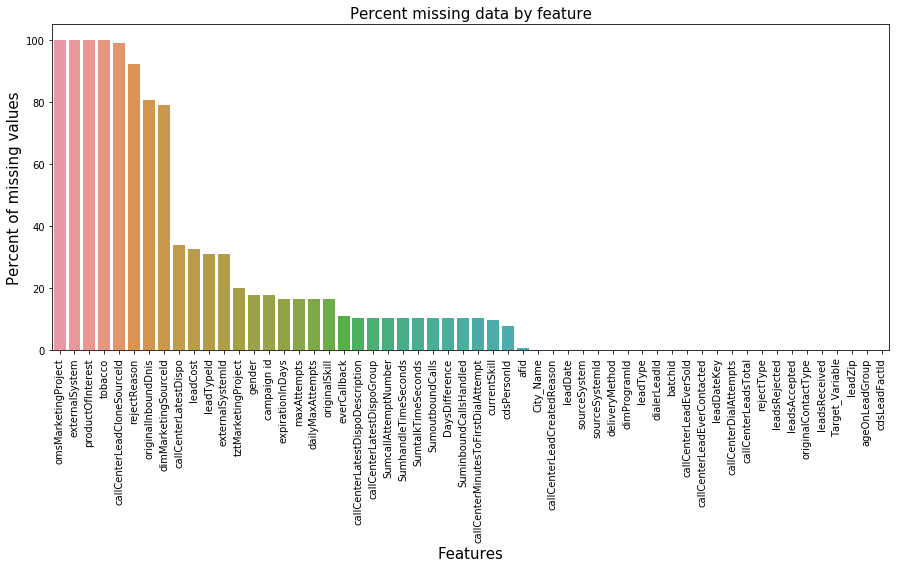

In [19]:
#Checking null and missing values values in dataset
total = Lead_Fact_Merged.isnull().sum().sort_values(ascending=False)
percent =100*(Lead_Fact_Merged.isnull().sum()/Lead_Fact_Merged.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head(10)

In [20]:
#Dropping all the Columns having missing values more than 50% and Lead Date Key
Lead_Fact_Merged.drop(['productOfInterest','tobacco','externalSystem','omsMarketingProject','callCenterLeadCloneSourceId',
'rejectReason','originalInboundDnis','dimMarketingSourceId','leadDateKey'], axis=1, inplace=True)

In [21]:
#Considering only Numeric Variables from Dataset
numerics = ['int32','int64','float64']
Lead_Fact_Merged_Numeric = Lead_Fact_Merged.select_dtypes(include=numerics)

In [22]:
Lead_Fact_Merged_Numeric.head()

,cdsLeadFactId,sourceSystem,cdsPersonId,dimProgramId,tztMarketingProject,dialerLeadId,afid,campaign id,originalContactType,leadTypeId,leadZip,ageOnLeadGroup,leadCost,callCenterLeadCreatedReason,callCenterDialAttempts,callCenterMinutesToFirstDialAttempt,leadsReceived,leadsAccepted,leadsRejected,rejectType,callCenterLeadsTotal,callCenterLeadEverContacted,callCenterLeadEverSold,currentSkill,originalSkill,expirationInDays,maxAttempts,dailyMaxAttempts,leadType,deliveryMethod,everCallback,DaysDifference,SuminboundCallsHandled,SumoutboundCalls,SumhandleTimeSeconds,SumtalkTimeSeconds,SumcallAttemptNumber,Target_Variable
0,13632067,2,7000068.0,7,377.0,2311300,363047.0,3.0,1,15.0,97106,4,50.0,7,5,2100.0,1,1,0,3,1,0,0,22.0,2.0,30.0,12.0,5.0,0,0,0.0,13.0,0.0,5.0,127.0,77.0,15.0,1
1,13632073,2,7000072.0,7,377.0,2311301,363047.0,3.0,1,15.0,47448,5,50.0,7,1,2097.0,1,1,0,3,1,1,0,2.0,2.0,30.0,12.0,5.0,0,0,0.0,0.0,0.0,1.0,802.0,779.0,1.0,1
2,13632079,2,NaN,7,377.0,1800166535724,354814.0,7.0,1,15.0,77803,5,0.0,7,0,NaN,1,0,1,2,0,0,0,NaN,NaN,NaN,NaN,NaN,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,13632093,2,7000089.0,7,377.0,2311310,363047.0,3.0,1,15.0,63114,4,50.0,7,7,2083.0,1,1,0,3,1,0,0,22.0,2.0,30.0,12.0,5.0,0,0,1.0,15.0,0.0,6.0,394.0,239.0,28.0,1
4,13632099,2,7000096.0,7,377.0,2311318,363045.0,3.0,1,15.0,77345,4,50.0,7,5,2063.0,1,1,0,3,1,0,0,22.0,2.0,30.0,12.0,5.0,0,0,0.0,13.0,0.0,5.0,396.0,60.0,15.0,1


In [23]:
Lead_Fact_Merged_Numeric.describe()

,cdsLeadFactId,sourceSystem,cdsPersonId,dimProgramId,tztMarketingProject,dialerLeadId,afid,campaign id,originalContactType,leadTypeId,leadZip,ageOnLeadGroup,leadCost,callCenterLeadCreatedReason,callCenterDialAttempts,callCenterMinutesToFirstDialAttempt,leadsReceived,leadsAccepted,leadsRejected,rejectType,callCenterLeadsTotal,callCenterLeadEverContacted,callCenterLeadEverSold,currentSkill,originalSkill,expirationInDays,maxAttempts,dailyMaxAttempts,leadType,deliveryMethod,everCallback,DaysDifference,SuminboundCallsHandled,SumoutboundCalls,SumhandleTimeSeconds,SumtalkTimeSeconds,SumcallAttemptNumber,Target_Variable
count,3.102000e+04,31020.000000,2.859800e+04,31020.0,24753.0,3.102000e+04,30779.000000,25512.000000,31020.000000,21358.000000,31020.000000,31020.000000,20906.000000,31020.000000,31020.000000,27776.000000,31020.000000,31020.000000,31020.000000,31020.000000,31020.000000,31020.000000,31020.000000,27996.000000,25896.000000,25854.0,25854.000000,25854.000000,31020.000000,31020.000000,27628.000000,27776.000000,27776.000000,27776.000000,27776.000000,27776.000000,27776.000000,31020.000000
mean,3.302131e+07,1.581399,2.658152e+07,7.0,377.0,1.655153e+11,363602.854056,12.149616,0.805996,14.948029,48495.132721,4.970922,127.016348,6.480690,4.256770,266.351382,0.790297,0.713024,0.077273,2.899710,0.901386,0.458221,0.053127,12.091549,2.276182,30.0,11.994276,4.999304,0.063217,0.191747,0.073947,4.269837,0.243736,4.289639,652.327369,455.658590,22.752700,0.588652
std,1.805735e+07,0.813136,1.800292e+07,0.0,0.0,5.272941e+11,67961.552986,6.543546,0.397471,0.507116,30979.277382,1.718361,956.521464,1.123351,4.280472,934.378351,0.407103,0.452358,0.267028,0.376842,0.298148,0.498259,0.224290,10.148077,2.772000,0.0,0.108287,0.045697,0.346445,0.393682,0.261689,13.448120,0.508785,4.438003,980.461373,910.708368,29.976079,0.558780
min,1.363207e+07,0.000000,7.000068e+06,7.0,377.0,2.311300e+06,16983.000000,1.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,30.0,10.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-33.000000,0.000000,0.000000
25%,1.386872e+07,2.000000,7.201182e+06,7.0,377.0,2.599558e+06,314603.000000,3.000000,1.000000,15.000000,23805.000000,4.000000,25.000000,7.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,2.000000,2.000000,30.0,12.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,153.000000,63.000000,1.000000,0.000000
50%,4.997175e+07,2.000000,4.330430e+07,7.0,377.0,2.960330e+06,363047.000000,17.000000,1.000000,15.000000,46669.000000,4.000000,50.000000,7.000000,2.000000,2.000000,1.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.000000,21.000000,2.000000,30.0,12.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,370.000000,147.000000,6.000000,1.000000
75%,5.033893e+07,2.000000,4.363792e+07,7.0,377.0,3.238081e+06,413338.000000,17.000000,1.000000,15.000000,77218.750000,5.000000,50.000000,7.000000,8.000000,52.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,0.000000,22.000000,2.000000,30.0,12.000000,5.000000,0.000000,0.000000,0.000000,4.000000,0.000000,8.000000,674.000000,367.000000,45.000000,1.000000
max,6.053321e+07,2.000000,4.487091e+07,7.0,377.0,3.000000e+12,999999.000000,19.000000,2.000000,15.000000,98512.000000,9.000000,11014.310000,8.000000,22.000000,42147.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,22.000000,22.000000,30.0,14.000000,5.000000,2.000000,1.000000,1.000000,183.000000,10.000000,15.000000,16540.000000,15261.000000,253.000000,2.000000


In [24]:
#As this data is not with critical or sensitive information, I am filling all the missing values
#For Few columns i'm using mean of column and some other where mean can't be valid due to categorical nature of the column,
#I'm using mode of the column.

#I am selecting these columns from intuition about impact on Target_Variable.
Mean_Cols=['leadCost','DaysDifference','SumtalkTimeSeconds']
Mode_Cols=['currentSkill','SuminboundCallsHandled','SumoutboundCalls']

Lead_Fact_Merged_Numeric[Mean_Cols]=Lead_Fact_Merged_Numeric[Mean_Cols].fillna(Lead_Fact_Merged_Numeric.mean().iloc[0])
Lead_Fact_Merged_Numeric[Mode_Cols]=Lead_Fact_Merged_Numeric[Mode_Cols].fillna(Lead_Fact_Merged_Numeric.mode().iloc[0])

Lead_Fact_Merged_Numeric.head()

,cdsLeadFactId,sourceSystem,cdsPersonId,dimProgramId,tztMarketingProject,dialerLeadId,afid,campaign id,originalContactType,leadTypeId,leadZip,ageOnLeadGroup,leadCost,callCenterLeadCreatedReason,callCenterDialAttempts,callCenterMinutesToFirstDialAttempt,leadsReceived,leadsAccepted,leadsRejected,rejectType,callCenterLeadsTotal,callCenterLeadEverContacted,callCenterLeadEverSold,currentSkill,originalSkill,expirationInDays,maxAttempts,dailyMaxAttempts,leadType,deliveryMethod,everCallback,DaysDifference,SuminboundCallsHandled,SumoutboundCalls,SumhandleTimeSeconds,SumtalkTimeSeconds,SumcallAttemptNumber,Target_Variable
0,13632067,2,7000068.0,7,377.0,2311300,363047.0,3.0,1,15.0,97106,4,50.0,7,5,2100.0,1,1,0,3,1,0,0,22.0,2.0,30.0,12.0,5.0,0,0,0.0,1.300000e+01,0.0,5.0,127.0,7.700000e+01,15.0,1
1,13632073,2,7000072.0,7,377.0,2311301,363047.0,3.0,1,15.0,47448,5,50.0,7,1,2097.0,1,1,0,3,1,1,0,2.0,2.0,30.0,12.0,5.0,0,0,0.0,0.000000e+00,0.0,1.0,802.0,7.790000e+02,1.0,1
2,13632079,2,NaN,7,377.0,1800166535724,354814.0,7.0,1,15.0,77803,5,0.0,7,0,NaN,1,0,1,2,0,0,0,22.0,NaN,NaN,NaN,NaN,2,0,NaN,3.302131e+07,0.0,1.0,NaN,3.302131e+07,NaN,1
3,13632093,2,7000089.0,7,377.0,2311310,363047.0,3.0,1,15.0,63114,4,50.0,7,7,2083.0,1,1,0,3,1,0,0,22.0,2.0,30.0,12.0,5.0,0,0,1.0,1.500000e+01,0.0,6.0,394.0,2.390000e+02,28.0,1
4,13632099,2,7000096.0,7,377.0,2311318,363045.0,3.0,1,15.0,77345,4,50.0,7,5,2063.0,1,1,0,3,1,0,0,22.0,2.0,30.0,12.0,5.0,0,0,0.0,1.300000e+01,0.0,5.0,396.0,6.000000e+01,15.0,1


In [25]:
#Exporting Data for Tableau Visualization
Lead_Fact_Merged.to_csv('Lead_Fact_Merged_Numeric_Filled.csv', encoding='utf-8')

## 2. Model Building : Supervised Machine Learning

In [26]:
#Finding Correlation w.r.t. Target_Variable
Correlation_Matrix=Lead_Fact_Merged_Numeric.corr()
Correlation_Matrix['Target_Variable'].sort_values()

callCenterLeadEverContacted           -0.408987
SuminboundCallsHandled                -0.254155
ageOnLeadGroup                        -0.238250
callCenterLeadsTotal                  -0.237883
deliveryMethod                        -0.231887
rejectType                            -0.195921
leadCost                              -0.127092
afid                                  -0.087208
leadTypeId                            -0.067933
maxAttempts                           -0.042380
campaign id                           -0.031170
dailyMaxAttempts                      -0.016746
cdsLeadFactId                          0.006853
cdsPersonId                            0.018447
callCenterMinutesToFirstDialAttempt    0.040821
leadsAccepted                          0.050657
everCallback                           0.052396
originalSkill                          0.069969
callCenterLeadCreatedReason            0.110042
leadType                               0.136332
leadZip                                0

In [27]:
#Confirming distribution of Target Variable. Here we can confirm distribution is skewed.
#Thus following 2 approaches, one is standard machine learning with weight imbalance feature of model
#and Adaptive Synthetic Oversampling Technique.
Lead_Fact_Merged_Numeric['Target_Variable'].value_counts()

1    16086
0    13847
2     1087
Name: Target_Variable, dtype: int64

In [28]:
# Considering only variables which are highly correlated with Target Variable
X=Lead_Fact_Merged_Numeric[['callCenterLeadEverContacted','ageOnLeadGroup','callCenterLeadsTotal','deliveryMethod',
                           'rejectType','SuminboundCallsHandled','leadCost','DaysDifference','callCenterLeadCreatedReason',
                           'leadType','SumtalkTimeSeconds','sourceSystem','originalContactType','callCenterDialAttempts',
                           'currentSkill','callCenterLeadEverSold','SumoutboundCalls']]
Y=Lead_Fact_Merged_Numeric['Target_Variable']

In [29]:
#Confirming if Machine Learning DataTest set having any missing values.
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31020 entries, 0 to 31019
Data columns (total 17 columns):
callCenterLeadEverContacted    31020 non-null int64
ageOnLeadGroup                 31020 non-null int32
callCenterLeadsTotal           31020 non-null int64
deliveryMethod                 31020 non-null int32
rejectType                     31020 non-null int32
SuminboundCallsHandled         31020 non-null float64
leadCost                       31020 non-null float64
DaysDifference                 31020 non-null float64
callCenterLeadCreatedReason    31020 non-null int32
leadType                       31020 non-null int32
SumtalkTimeSeconds             31020 non-null float64
sourceSystem                   31020 non-null int32
originalContactType            31020 non-null int32
callCenterDialAttempts         31020 non-null int64
currentSkill                   31020 non-null float64
callCenterLeadEverSold         31020 non-null int64
SumoutboundCalls               31020 non-null flo

In [30]:
#Dataset split is 80% Training and 20% Test
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.2, random_state=42)

### 2.1 Extra Tree Classifier 

In [31]:
#Extra Tree Classifier
from sklearn.ensemble import ExtraTreesClassifier
Extra_Tree=ExtraTreesClassifier(max_depth=8,random_state=42,n_estimators=100)
Extra_Tree.fit(X_Train,Y_Train)
Y_Pred_Extra_Tree=Extra_Tree.predict(X_Test)

In [32]:
print("Accuracy of Extra Tree Classifier is",accuracy_score(Y_Test,Y_Pred_Extra_Tree))
CM_Log=confusion_matrix(Y_Test,Y_Pred_Extra_Tree)
print('\n')
print("Classification Report for Extra Tree Classifier is")
print(classification_report(Y_Test,Y_Pred_Extra_Tree))
pd.crosstab(Y_Test,Y_Pred_Extra_Tree,rownames=['True'], colnames=['Predicted'],margins=True)

Accuracy of Extra Tree Classifier is 0.8567053513862024


Classification Report for Extra Tree Classifier is
              precision    recall  f1-score   support

           0       0.79      0.93      0.85      2733
           1       0.94      0.80      0.86      3266
           2       0.79      0.88      0.84       205

   micro avg       0.86      0.86      0.86      6204
   macro avg       0.84      0.87      0.85      6204
weighted avg       0.87      0.86      0.86      6204



Predicted,0,1,2,All
True,,,,
0,2533,161,39,2733
1,657,2601,8,3266
2,24,0,181,205
All,3214,2762,228,6204


How to Evaluate Model Output?

1. Accuracy can be deceiving in Classification Problem. Especially when data is not equally distributed. In our case, base line probability is at 52.64%. This is probability of majority class i.e. class 1. This indicates if we select any sample and assign it to class 1, there is 52.64% chances that your prediction is correct.
2. I have acquired 85.84% accuracy in this model, which is further improved in next few models. My accuracy is 33.2% above the baseline. My best model yields around 90% accuracy.
3. In my assessment, I'm mainly focusing on F1 Score rather than accuracy. F1 Score is harmonic mean of Precision and Recall. 
4. I have also added Confusion Matrix. This way, we can get a better idea about how Target Variable is being classified in model output. Using these both Metrices, I have tried to optimize the Sales prediction in model output. 


### 2.2 Random Forest Classifier

In [33]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
#Using Class_Weight feature to handle the class imbalance
Rand_For=RandomForestClassifier(random_state=42, class_weight='balanced')
Rand_For.fit(X_Train, Y_Train)
Y_Pred_Rand_For=Rand_For.predict(X_Test)

#Results
print("Accuracy of Random Forest Classifier is",accuracy_score(Y_Test,Y_Pred_Rand_For))
print('\n')
print(classification_report(Y_Test,Y_Pred_Rand_For))
pd.crosstab(Y_Test,Y_Pred_Rand_For,rownames=['True'], colnames=['Predicted'],margins=True)

Accuracy of Random Forest Classifier is 0.8625080593165699


              precision    recall  f1-score   support

           0       0.82      0.88      0.85      2733
           1       0.90      0.85      0.88      3266
           2       0.85      0.79      0.82       205

   micro avg       0.86      0.86      0.86      6204
   macro avg       0.86      0.84      0.85      6204
weighted avg       0.86      0.86      0.86      6204



Predicted,0,1,2,All
True,,,,
0,2407,301,25,2733
1,480,2782,4,3266
2,42,1,162,205
All,2929,3084,191,6204


Here F1 Score is almost similar as previous model and Confusion Matrix is not as good as previous model w.r.t. Sales. Thus I'm implementing hyperparameter tuning to optimize the results of Random Forest.

#### 2.2.1 Hyperparameter Tuning for Random Forest 

In [34]:
#To find the best parameters of model for highly accurate results, I am performing hyperparameter tuning.
#There are 2 approached, Grid Search and Random Search. Random Search in computationally exhaustiv technique,
#From previous model, I have a better idea about parameters range, thus specifying range of each parameter below.

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [50,100,125,150,175,200,225,250,275,300]
# Number of features to consider at every split
max_features = [2,4,6,8,10]
# Maximum number of levels in tree
max_depth = [2,4,8,12]
# Minimum number of samples required to split a node
min_samples_split = [2, 5,8,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
criterion=['gini','entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion
              }
print(random_grid)

{'n_estimators': [50, 100, 125, 150, 175, 200, 225, 250, 275, 300], 'max_features': [2, 4, 6, 8, 10], 'max_depth': [2, 4, 8, 12], 'min_samples_split': [2, 5, 8, 10], 'min_samples_leaf': [1, 2, 4, 6, 8], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}


In [35]:
Rand_For_Tuned = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
Rand_For_Tuned_random = RandomizedSearchCV(estimator = Rand_For_Tuned, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
Rand_For_Tuned_random.fit(X_Train,Y_Train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100, 125, 150, 175, 200, 225, 250, 275, 300], 'max_features': [2, 4, 6, 8, 10], 'max_depth': [2, 4, 8, 12], 'min_samples_split': [2, 5, 8, 10], 'min_samples_leaf': [1, 2, 4, 6, 8], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [36]:
#Getting the best parameters
Rand_For_Tuned_random.best_params_

{'n_estimators': 175,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 4,
 'max_depth': 12,
 'criterion': 'gini',
 'bootstrap': False}

In [37]:
#Random Forest Classfier: Hyper Parameter Tuned
Random_Forest_Tuned=RandomForestClassifier(max_depth=12, random_state=42, n_estimators=150,min_samples_split=5,
                               min_samples_leaf=4,max_features=4,bootstrap=False,criterion='entropy')
model2=Random_Forest_Tuned.fit(X_Train, Y_Train)
Y_Pred_Random_Forest_Tuned=Random_Forest_Tuned.predict(X_Test)

#Results
print("Accuracy of Tuned Random Forest Classifier is",accuracy_score(Y_Test,Y_Pred_Random_Forest_Tuned))
print('\n')
print(classification_report(Y_Test,Y_Pred_Random_Forest_Tuned))
pd.crosstab(Y_Test,Y_Pred_Random_Forest_Tuned,rownames=['True'], colnames=['Predicted'],margins=True)

Accuracy of Tuned Random Forest Classifier is 0.8865248226950354


              precision    recall  f1-score   support

           0       0.82      0.95      0.88      2733
           1       0.96      0.83      0.89      3266
           2       0.84      0.85      0.85       205

   micro avg       0.89      0.89      0.89      6204
   macro avg       0.88      0.88      0.87      6204
weighted avg       0.90      0.89      0.89      6204



Predicted,0,1,2,All
True,,,,
0,2600,103,30,2733
1,538,2726,2,3266
2,31,0,174,205
All,3169,2829,206,6204


Here, I am able to achive substantial resutls as compared to previous model. Precision and Recall for all the classes are increased, this impacted in increase of F1 Score.

### 2.3  Gradient Boosting Classifier

In [38]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
Gradient_Boosting=GradientBoostingClassifier(max_depth=4)
Grad_Boost=Gradient_Boosting.fit(X_Train,Y_Train)
Y_Pred_Grad_Boost=Grad_Boost.predict(X_Test)

#Results
print("Accuracy of Gradient Boosting Classifier is",accuracy_score(Y_Test,Y_Pred_Grad_Boost))
print('\n')
print(classification_report(Y_Test,Y_Pred_Grad_Boost))
pd.crosstab(Y_Test,Y_Pred_Grad_Boost,rownames=['True'], colnames=['Predicted'],margins=True)


Accuracy of Gradient Boosting Classifier is 0.8878143133462283


              precision    recall  f1-score   support

           0       0.83      0.95      0.88      2733
           1       0.96      0.84      0.90      3266
           2       0.85      0.88      0.86       205

   micro avg       0.89      0.89      0.89      6204
   macro avg       0.88      0.89      0.88      6204
weighted avg       0.90      0.89      0.89      6204



Predicted,0,1,2,All
True,,,,
0,2583,119,31,2733
1,519,2745,2,3266
2,24,1,180,205
All,3126,2865,213,6204


### 2.4  Voting Classifier

In [39]:
#Voting Classifier
#To have highly accurate and low biased(avoiding overfitting) model, I am using Voting Classifier to score commonly across all the 3 models.
#Voting Classifer merge the results of all 3 classifiers to yield better results.
from sklearn.ensemble import VotingClassifier
Voting_Classifier=VotingClassifier(estimators=[('Extra_Tree',Extra_Tree),('Gradient_Boosting',Gradient_Boosting),('Random_Forest_Tuned',Random_Forest_Tuned)],
                                  voting='soft')

for clf in (Extra_Tree,Gradient_Boosting,Rand_For,Voting_Classifier):
    clf.fit(X_Test,Y_Test)
    #Considdering Probabilities of Sale, Predictive Sale and No Sale
    Sales_Probability_Distribution=clf.predict_proba(X_Test)[:,2]
    Predictive_Sales_Probability_Distribution=clf.predict_proba(X_Test)[:,1]
    No_Sales_Probability_Distribution=clf.predict_proba(X_Test)[:,0]
    
    #All final values
    Voting_Pred=clf.predict(X_Test)

In [40]:
#Results
print("Accuracy of Voting Classifier is",accuracy_score(Y_Test,Voting_Pred))
print('\n')
print(classification_report(Y_Test,Voting_Pred))
pd.crosstab(Y_Test,Voting_Pred,rownames=['True'], colnames=['Predicted'],margins=True)

Accuracy of Voting Classifier is 0.8995809155383624


              precision    recall  f1-score   support

           0       0.84      0.96      0.89      2733
           1       0.96      0.85      0.90      3266
           2       0.94      0.99      0.96       205

   micro avg       0.90      0.90      0.90      6204
   macro avg       0.91      0.93      0.92      6204
weighted avg       0.91      0.90      0.90      6204



Predicted,0,1,2,All
True,,,,
0,2616,107,10,2733
1,499,2763,4,3266
2,3,0,202,205
All,3118,2870,216,6204


In [41]:
#This distribution provides an idea, how score is distributed across the multiple bins in target variable
hist,bins = np.histogram(Voting_Pred, bins =[0,0.2,0.4,0.6,0.8,1]) 
print (hist)
print (bins)

[3118    0    0    0 2870]
[0.  0.2 0.4 0.6 0.8 1. ]


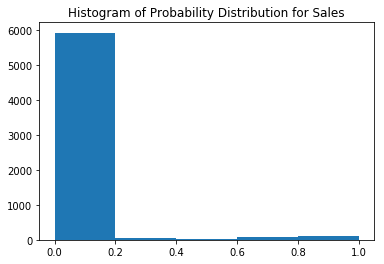

In [42]:
plt.hist(Sales_Probability_Distribution, bins = [0,0.2,0.4,0.6,0.8,1])
plt.title("histogram") 
plt.title('Histogram of Probability Distribution for Sales')
plt.show()

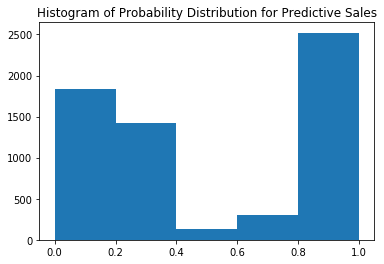

In [43]:
plt.hist(Predictive_Sales_Probability_Distribution, bins = [0,0.2,0.4,0.6,0.8,1])
plt.title("histogram") 
plt.title('Histogram of Probability Distribution for Predictive Sales')
plt.show()

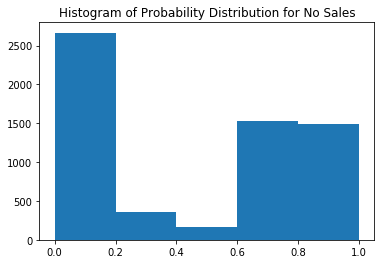

In [44]:
plt.hist(No_Sales_Probability_Distribution, bins = [0,0.2,0.4,0.6,0.8,1])
plt.title("histogram") 
plt.title('Histogram of Probability Distribution for No Sales')
plt.show()

1. Voting Model outperfoms all the individual model. It is giving best Confusion Matrix and better F1 Score as compared to any previous model. Thus Voting Classifier is succesful technique to quantify results across all the 3 models.
2. Above model is providing good results but I am using ADASYN Oversampling Technique, to test a case if data is balanced across target variable, will it increase the prediction power of a model.
3. Below are the results of ADASYN. This ADASYN model is for experimentation purpose only.

### 2.5 ADASYN Technique: Random Forest Model 

In [45]:
#Balancing the data using Adaptive Synthetic Oversampling Technique
ada=ADASYN()
X_Resampled, Y_Resampled=ada.fit_sample(X_Train,Y_Train)
unique, counts=np.unique(Y_Resampled,return_counts= True)
print("Balanced Unique Count for each classes is:")
print(unique, counts)

Balanced Unique Count for each classes is:
[0 1 2] [11525 12820 12816]


In [46]:
#Random Forest Classfier: Hyper Parameter Tuned ADASYN Oversamples
Random_Forest_Tuned_ADASYN=RandomForestClassifier(max_depth=12, random_state=42, n_estimators=150,min_samples_split=5,
                               min_samples_leaf=4,max_features=4,bootstrap=False,criterion='entropy')
Random_Forest_Tuned_ADASYN.fit(X_Resampled, Y_Resampled)
Y_Pred_Random_Forest_Tuned_ADASYN=Random_Forest_Tuned_ADASYN.predict(X_Test)

#Results
print("Accuracy of Tuned Random Forest Classifier with ADASYN Oversampling is",accuracy_score(Y_Test,Y_Pred_Random_Forest_Tuned_ADASYN))
print('\n')
print(classification_report(Y_Test,Y_Pred_Random_Forest_Tuned_ADASYN))
pd.crosstab(Y_Test,Y_Pred_Random_Forest_Tuned_ADASYN,rownames=['True'], colnames=['Predicted'],margins=True)

Accuracy of Tuned Random Forest Classifier with ADASYN Oversampling is 0.8853965183752418


              precision    recall  f1-score   support

           0       0.83      0.94      0.88      2733
           1       0.96      0.84      0.89      3266
           2       0.75      0.95      0.84       205

   micro avg       0.89      0.89      0.89      6204
   macro avg       0.85      0.91      0.87      6204
weighted avg       0.90      0.89      0.89      6204



Predicted,0,1,2,All
True,,,,
0,2569,107,57,2733
1,529,2730,7,3266
2,11,0,194,205
All,3109,2837,258,6204


1. From the above result, I can confirm that there is no substantial gain after introducing Adaptive Synthetic Oversampling Technique into the model.
2. Drawback of this method is, it's like introducing noise into the dataset.
3. This model was for experimentation purpose only. I am continuing with Voting Classifier as my most reliable model.

### 2.6 Business Analyis of Models

In [47]:
#Merging both X and Y feature created at the Data Split.
#This is the dataset used for machine learning algorithms.
ML_Analysis_Data=X
ML_Analysis_Data['Target_Variable']=Y

In [48]:
#Considering data points for each type of target variable and taking their mean values.
No_Sale = ML_Analysis_Data[ML_Analysis_Data['Target_Variable'] == 0]
No_Sale_Mean_Values = No_Sale.mean()

Predictive_Sale = ML_Analysis_Data[ML_Analysis_Data['Target_Variable'] == 1]
Predictive_Sale_Mean_Values = Predictive_Sale.mean()

Sale = ML_Analysis_Data[ML_Analysis_Data['Target_Variable'] == 2]
Sale_Mean_Values = Sale.mean()

No_Sale_Mean_Values = No_Sale_Mean_Values.reset_index()
Predictive_Sale_Mean_Values = Predictive_Sale_Mean_Values.reset_index()
Sale_Mean_Values = Sale_Mean_Values.reset_index()

No_Sale_Mean_Values = No_Sale_Mean_Values.rename(columns={'index': 'Features',0 : 'Mean_Values_No_Sale'})
Predictive_Sale_Mean_Values = Predictive_Sale_Mean_Values.rename(columns={'index': 'Features',0 : 'Mean_Values_Predictive_Sale'})
Sale_Mean_Values = Sale_Mean_Values.rename(columns={'index': 'Features',0 : 'Mean_Values_Sale'})

In [49]:
#Merging all the 3 datasets on the basis of feature 
No_Sale_Mean_Values.merge(Predictive_Sale_Mean_Values,on='Features').merge(Sale_Mean_Values,on='Features')

,Features,Mean_Values_No_Sale,Mean_Values_Predictive_Sale,Mean_Values_Sale
0,callCenterLeadEverContacted,7.558316e-01,1.654233e-01,1.000000e+00
1,ageOnLeadGroup,5.481548e+00,4.532948e+00,4.947562e+00
2,callCenterLeadsTotal,9.979057e-01,8.116374e-01,1.000000e+00
3,deliveryMethod,3.162418e-01,7.578018e-02,3.219871e-01
4,rejectType,3.000000e+00,2.806602e+00,3.000000e+00
5,SuminboundCallsHandled,3.927927e-01,5.116250e-02,4.673413e-01
6,leadCost,1.370512e+07,7.827398e+06,1.682970e+07
7,DaysDifference,3.261140e+00,6.659282e+06,2.931923e+00
8,callCenterLeadCreatedReason,6.232830e+00,6.774214e+00,5.294388e+00
9,leadType,1.444356e-04,1.209126e-01,1.287948e-02


Analysis:
1. Above matrix consists of all the features considered in model building and their respective means for example , First columns represent the mean of all the features w.r.t. No Sale and so on
2. From the confusion matrix from the model output, it was evident that model was clearly identifying Predictive Sales i.e. 2, but if was confused between No Sale and Sale,
3. This can be validated from above matrix. I can confirm that mean values for most of the features for No Sale and Sale are almost similar and this was the main reason for model getting confused between these classes.
4. From the output probability distribution of Voting Classifier for each class, I can implement better customer segmentation and effective targeted marketing. 
5. I believe with the help of some more distinguishable features and some of business understanding, I can further improve my model output. 


## 3. Model Building : Unsupervised Machine Learning

From the previous model building, X is all the numerical data we have passed to Machine Learning Models. Using same data and selecting  only 'SuminboundCallsHandled', 'SumtalkTimeSeconds', 'SumoutboundCalls' features from that dataset for Unsupervised Machine Learning

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31020 entries, 0 to 31019
Data columns (total 18 columns):
callCenterLeadEverContacted    31020 non-null int64
ageOnLeadGroup                 31020 non-null int32
callCenterLeadsTotal           31020 non-null int64
deliveryMethod                 31020 non-null int32
rejectType                     31020 non-null int32
SuminboundCallsHandled         31020 non-null float64
leadCost                       31020 non-null float64
DaysDifference                 31020 non-null float64
callCenterLeadCreatedReason    31020 non-null int32
leadType                       31020 non-null int32
SumtalkTimeSeconds             31020 non-null float64
sourceSystem                   31020 non-null int32
originalContactType            31020 non-null int32
callCenterDialAttempts         31020 non-null int64
currentSkill                   31020 non-null float64
callCenterLeadEverSold         31020 non-null int64
SumoutboundCalls               31020 non-null flo

In [51]:
#Collective Unsupervised Data with only 3 Columns.
Unsupervised_Data= X[['SuminboundCallsHandled','SumtalkTimeSeconds','SumoutboundCalls']]
Unsupervised_Data.head()

,SuminboundCallsHandled,SumtalkTimeSeconds,SumoutboundCalls
0,0.0,7.700000e+01,5.0
1,0.0,7.790000e+02,1.0
2,0.0,3.302131e+07,1.0
3,0.0,2.390000e+02,6.0
4,0.0,6.000000e+01,5.0


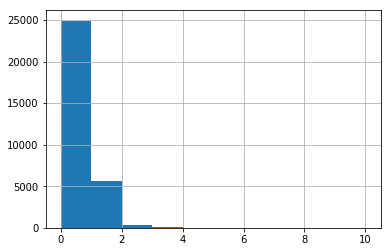

In [52]:
Unsupervised_Data['SuminboundCallsHandled'].hist()

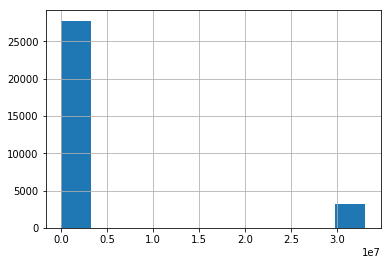

In [53]:
Unsupervised_Data['SumtalkTimeSeconds'].hist()

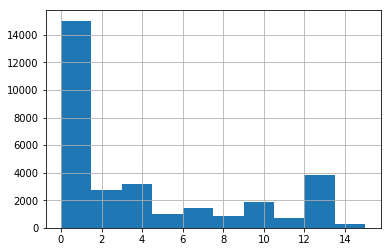

In [54]:
Unsupervised_Data['SumoutboundCalls'].hist()

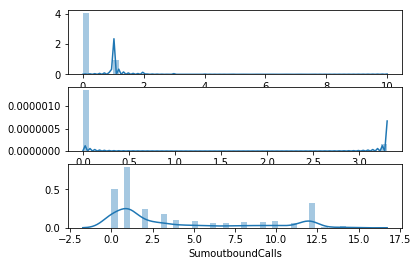

In [55]:
# Plotting SuminboundCallsHandled distribution
plt.subplot(3, 1, 1); sns.distplot(Unsupervised_Data['SuminboundCallsHandled'])

# Plotting SumtalkTimeSeconds distribution
plt.subplot(3, 1, 2); sns.distplot(Unsupervised_Data['SumtalkTimeSeconds'])

# Plotting SumoutboundCalls value distribution
plt.subplot(3, 1, 3); sns.distplot(Unsupervised_Data['SumoutboundCalls'])

# Displaying the plot
plt.show()

In [56]:
#As data is not normally distributed, taking log of data to make it as close as normal distribution
Unsupervised_Data['SuminboundCallsHandled'] = np.log(Unsupervised_Data['SuminboundCallsHandled'] )
Unsupervised_Data['SumtalkTimeSeconds'] = np.log(Unsupervised_Data['SumtalkTimeSeconds'] )
Unsupervised_Data['SumoutboundCalls'] = np.log(Unsupervised_Data['SumoutboundCalls'] )

In [57]:
#As Log can give - infinity values, handling those errors
Unsupervised_Data = Unsupervised_Data.replace([np.inf, -np.inf], np.nan)
Unsupervised_Data =  Unsupervised_Data.fillna(0)

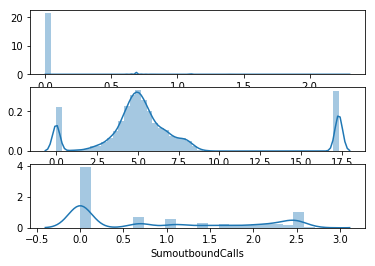

In [58]:
# Plotting SuminboundCallsHandled distribution to cofirm change in distribution
plt.subplot(3, 1, 1); sns.distplot(Unsupervised_Data['SuminboundCallsHandled'])

# Plotting SumtalkTimeSeconds distribution
plt.subplot(3, 1, 2); sns.distplot(Unsupervised_Data['SumtalkTimeSeconds'])

# Plotting SumoutboundCalls value distribution
plt.subplot(3, 1, 3); sns.distplot(Unsupervised_Data['SumoutboundCalls'])

# Displaying the plot
plt.show()

In [59]:
#Using Standard Scaler to Normalize the Data.
scaler = StandardScaler()
scaler.fit(Unsupervised_Data)

#Scaling and centering the data
Unsupervised_Data_normalized = scaler.transform(Unsupervised_Data)

#Creating dataframe
Modeled_segmented_Unsupervised_Data_normalized = pd.DataFrame(data=Unsupervised_Data, index=Unsupervised_Data.index, columns=Unsupervised_Data.columns)

In [60]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(Modeled_segmented_Unsupervised_Data_normalized)
    wcss.append(kmeans.inertia_)
    

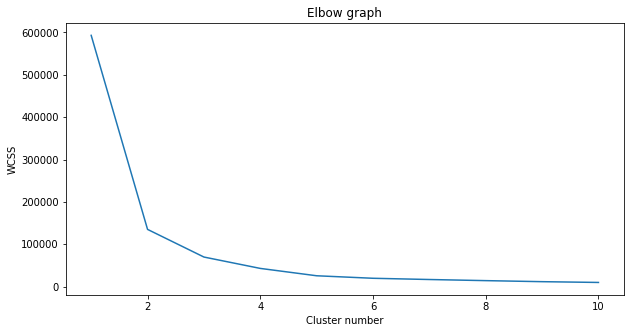

In [61]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

In [62]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(Unsupervised_Data)
centroids = kmeans.cluster_centers_

In [63]:
centroids = pd.DataFrame(centroids, columns = ['SuminboundCallsHandled' , 'SumtalkTimeSeconds', 'SumoutboundCalls'], index=['Cluster0', 'Cluster1', 'Cluster2','Cluster3'])

In [64]:
centroids

,SuminboundCallsHandled,SumtalkTimeSeconds,SumoutboundCalls
Cluster0,1.047436e-03,4.650000,1.254354e+00
Cluster1,3.469447e-16,17.312664,-2.187139e-14
Cluster2,2.274105e-04,0.460236,8.867406e-01
Cluster3,4.688184e-02,6.808491,5.303135e-01


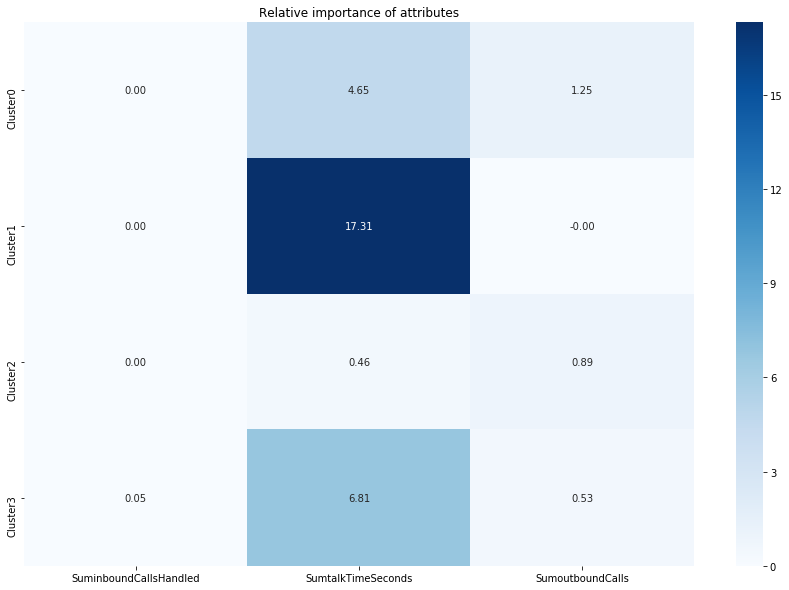

In [65]:
#Importance of each feature for each cluster
plt.figure(figsize=(15, 10))
plt.title('Relative importance of attributes')
sns.heatmap(data=centroids, annot=True, fmt='.2f', cmap='Blues')
plt.show()

In [66]:
#Assigning Clusters to each datapoint
Lead_Fact_Merged_Numeric['clusters'] = clusters
Unsupervised_Data['clusters'] = clusters
Unsupervised_Data.head()

,SuminboundCallsHandled,SumtalkTimeSeconds,SumoutboundCalls,clusters
0,0.0,4.343805,1.609438,0
1,0.0,6.658011,0.000000,3
2,0.0,17.312664,0.000000,1
3,0.0,5.476464,1.791759,0
4,0.0,4.094345,1.609438,0


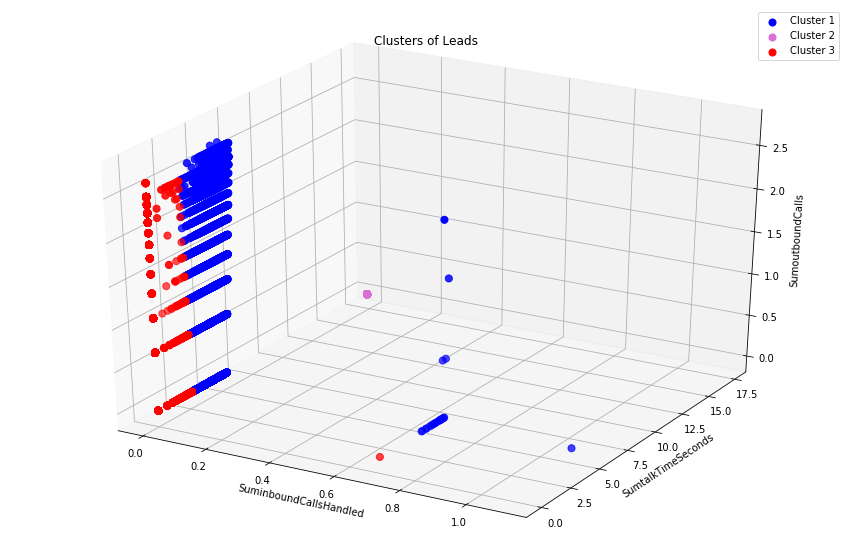

In [67]:
fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['blue', 'orchid', 'red']

for i in range(0,3):
    dx.scatter(Unsupervised_Data[Unsupervised_Data.clusters == i].SuminboundCallsHandled, 
               Unsupervised_Data[Unsupervised_Data.clusters == i].SumtalkTimeSeconds, 
               Unsupervised_Data[Unsupervised_Data.clusters == i].SumoutboundCalls, 
               c = colors[i], 
               label = 'Cluster ' + str(i+1), 
               s=50)

dx.set_title('Clusters of Leads')
dx.set_xlabel('SuminboundCallsHandled')
dx.set_ylabel('SumtalkTimeSeconds')
dx.set_zlabel('SumoutboundCalls')
dx.legend()

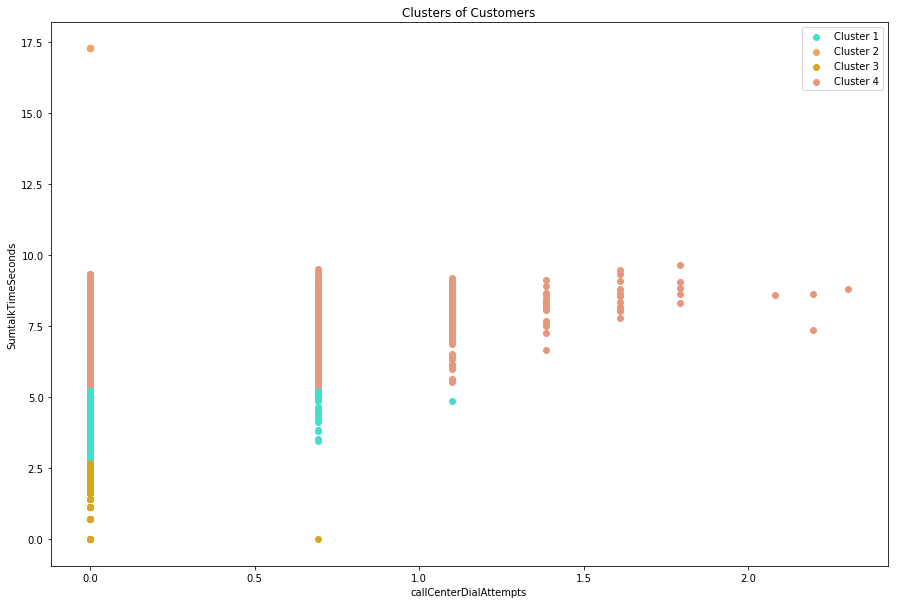

In [68]:
plt.rcParams["figure.figsize"] = (15,10)
c1 = Unsupervised_Data[Unsupervised_Data.clusters == 0]
c2 = Unsupervised_Data[Unsupervised_Data.clusters == 1]
c3 = Unsupervised_Data[Unsupervised_Data.clusters == 2]
c4 = Unsupervised_Data[Unsupervised_Data.clusters == 3]


plt.scatter(c1.SuminboundCallsHandled, c1.SumtalkTimeSeconds, c = 'turquoise', label = 'Cluster 1')
plt.scatter(c2.SuminboundCallsHandled, c2.SumtalkTimeSeconds, c = 'sandybrown', label = 'Cluster 2')
plt.scatter(c3.SuminboundCallsHandled, c3.SumtalkTimeSeconds, c = 'goldenrod', label = 'Cluster 3')
plt.scatter(c4.SuminboundCallsHandled, c4.SumtalkTimeSeconds, c = 'darksalmon', label = 'Cluster 4')

plt.title('Clusters of Customers')
plt.xlabel('callCenterDialAttempts')
plt.ylabel('SumtalkTimeSeconds')
plt.legend()

In [69]:
#This section is used in creating business insight. Details are mentioned in attached report.
Sale = Lead_Fact_Merged_Numeric[Lead_Fact_Merged_Numeric['Target_Variable'] == 2]
print('Sales dialLeadIDs are distributed as below in different clusters')
print(Sale['clusters'].value_counts())

print('Total Datapoints associated with each cluster')
Lead_Fact_Merged_Numeric['clusters'].value_counts()

Sales dialLeadIDs are distributed as below in different clusters
3    936
2    144
0      7
Name: clusters, dtype: int64
Total Datapoints associated with each cluster


0    16923
3     7805
1     3244
2     3048
Name: clusters, dtype: int64

## 4. Cost Based Analysis 

1. There are many parameters involved in cost-based analysis. Like how many hours are invested in the lead, how we are earning profit from each lead, what are the other operational charges and so on. But in our dataset, there is only 1 column associated with Cost i.e. Lead Cost. Thus, proceeding with only Lead Cost for Cost Based Analysis.
2. I am using most simple formula for calculating the money saved and money lost. Suppose, as per the data, dialLeadID is No Sale and my model correctly identifies it, then I wouldn't suggest investing in that lead further. That will be amount saved.
3. Suppose the original value of the lead is No Sale but my model predicted it as Predictive Sale or Sale, and we followed and invested in that lead then it is counted as money lost.
4. There are many other complications in Cost Based Analysis, but this section is only for experimentation purpose. Thus, proceeding with available data and above-mentioned strategies.
5. One of the pitfalls in this analysis is, we have used data filling techniques in while data preprocessing. In That process, we have filled the missing values from leadCost via mean of column. This Introduced around 32% new values all with mean of column. This will add extra money in calculation, thus here I'm using Lead_Fact_Merged Data, which is in it's raw form w.r.t leadCost. There are only 20906 non null entries in leadCost and all are provided in original dataset.


In [70]:
# We need only dialLeadId and Actual Target Variable. But as we have done predictions on test set, reiterating the same 
# split process to ensure same associated IDs.
X_CBA=Lead_Fact_Merged[['dialerLeadId','leadCost']]
Y_CBA=Lead_Fact_Merged['Target_Variable']

#Dataset split is 80% Training and 20% Test
X_Train_CBA, X_Test_CBA, Y_Train_CBA, Y_Test_CBA = train_test_split(X_CBA, Y_CBA, test_size=0.2, random_state=42)

In [71]:
X_Test_CBA['Actual_Value']=Y_Test_CBA
X_Test_CBA['Voting_Classifier_Prediction']=Voting_Pred
X_Test_CBA.head()

,dialerLeadId,leadCost,Actual_Value,Voting_Classifier_Prediction
3068,2344850,50.00,1,0
9644,2614351,50.00,0,0
13640,2693722,25.00,1,1
1090,2000001863455,50.00,1,1
21739,3093148,13.76,1,1


In [72]:
#Calculating_Finincial_Impact
def Money_Saved(leadCost,Actual_Value,Voting_Classifier_Prediction):
    #Setting Default value as 0
    output=0
    if Actual_Value==Voting_Classifier_Prediction:
        if Actual_Value==0:
            output=leadCost
    else:
        output= 0
        
    return output

def Money_Lost(leadCost,Actual_Value,Voting_Classifier_Prediction):
    #Setting Default value as 0
    output=0
    if Actual_Value!=Voting_Classifier_Prediction:
        if Actual_Value==0:
            output=leadCost
    else:
        output= 0
        
    return output


X_Test_CBA['Money_Saved']=X_Test_CBA.apply(lambda x: Money_Saved(x.leadCost,x.Actual_Value,x.Voting_Classifier_Prediction),axis=1)
X_Test_CBA['Money_Lost']=X_Test_CBA.apply(lambda x: Money_Lost(x.leadCost,x.Actual_Value,x.Voting_Classifier_Prediction),axis=1)

X_Test_CBA.head()

,dialerLeadId,leadCost,Actual_Value,Voting_Classifier_Prediction,Money_Saved,Money_Lost
3068,2344850,50.00,1,0,0.0,0.0
9644,2614351,50.00,0,0,50.0,0.0
13640,2693722,25.00,1,1,0.0,0.0
1090,2000001863455,50.00,1,1,0.0,0.0
21739,3093148,13.76,1,1,0.0,0.0


In [73]:
Total_Money_Saved=X_Test_CBA['Money_Saved'].sum().round()
Total_Money_Lost=X_Test_CBA['Money_Lost'].sum().round()
Profit=Total_Money_Saved-Total_Money_Lost
print("Total Money Saved in this project is:", Total_Money_Saved , ", Total Money Lost is:", Total_Money_Lost, 
      ", and Net Profit of projecct is:" , Profit)

Total Money Saved in this project is: 240730.0 , Total Money Lost is: 4120.0 , and Net Profit of projecct is: 236610.0


In [74]:
#Here converting machine learning output into actionable file.
#This file should be submitted to each sales representative for optimized results.
Business_Output=X_Test_CBA[['dialerLeadId']]
Business_Output['Final_Output']=Voting_Pred
Business_Output['Sales_Probability']=Sales_Probability_Distribution*100
Business_Output['Predictive_Sales_Probability']=Predictive_Sales_Probability_Distribution*100
Business_Output['No_Sales_Probability']=No_Sales_Probability_Distribution*100
Business_Output.head()

,dialerLeadId,Final_Output,Sales_Probability,Predictive_Sales_Probability,No_Sales_Probability
3068,2344850,0,0.221035,15.675817,84.103148
9644,2614351,0,0.606431,22.200501,77.193068
13640,2693722,1,0.003355,97.923826,2.072818
1090,2000001863455,1,0.003032,99.861870,0.135098
21739,3093148,1,0.016062,91.690848,8.293090


In [75]:
#Exporting final output for sales representative.
Business_Output.to_csv('Business_Output.csv', encoding='utf-8')

## 5. Business Recommendation

1. Above model predicts the possibility of Sale, No Sale and who can be predictive customer.Class 1 says no Sale, 2 says predictive sale and 3 means sale. 
2. Output file consists of each LeadId with probability of each sale. To optimize the conversion rate, sort all the probabilities in descending order and start dialing from top.
3. First complete all the Ids from Sale section, then predictive Sale section with descending probabilities. This way we can maximize the conversion rate.
4. If we want to plan Targeted Marketing campaign, I will focus on Leads from predictive marketing section. All the customers with predictive sale probability around 0.3-0.7 are the ideal candidate to include in targeted marketing to increase the sales. These customers can be identified from Predictive_Sales_Probability_Distribution graph from Voting Classifier.
5. Using both unsupervised and supervised learning, I can validate, model is getting confused between NoSale and Sale Variable. Thus, I would discuss with business and come up with new variable which will be more impactful to create distinction between these classes.

Submitted by Sudesh V Khillare